# Theory Model of Aircraft

Header Files

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pickle
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt     

Load Moduel

In [31]:

# Load the RandomForestRegressor model from the 'scaler.pkl' file
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

Function 1

### Main Block

In [32]:

def dynamics(p, q, r, u, v, w, phi, theta, psi, X, Y, Z, L, M, N):
    # Constants
    m = 0.45
    g = 9.81
    Ix, Iy, Iz = 0.008965, 0.009146, 0.017975
    Ixz = -0.000274

    # Initialize outputs (to be calculated

    # Translational accelerations
    u_dot = ((X - (m * g * np.sin(theta))) / m) + (r * v - q * w)
    v_dot = ((Y + (m * g * np.sin(phi) * np.cos(theta))) / m) - r * u + p * w
    w_dot = ((Z + (m * g * np.cos(phi) * np.cos(theta))) / m) - p * v + q * u

    # Rotational accelerations
    r_dot = (((Ixz / Ix) * (L + ((Iy - Iz) * q * r) + (Ixz * p * q))) +
             ((Ix - Iy) * p * q - Ixz * r * q + N)) / (Iz - (Ixz**2 / Ix))
    p_dot = (L + (Ixz * r_dot) + ((Iy - Iz) * q * r) + (Ixz * p * q)) / Ix
    q_dot = (M + (Iz - Ix) * p * r - (Ixz * (p**2 - r**2))) / Iy

    # Angular rates
    phi_dot = p + (q * np.sin(phi) * np.tan(theta) + r * np.cos(phi) * np.tan(theta))
    theta_dot = q * np.cos(phi) - r * np.sin(phi)
    psi_dot = (q * np.sin(phi) / np.cos(theta)) + (r * np.cos(phi) / np.cos(theta))

    # Return the calculated translational and rotational rates
    return {
        'u_dot': u_dot, 'v_dot': v_dot, 'w_dot': w_dot,
        'r_dot': r_dot, 'p_dot': p_dot, 'q_dot': q_dot,
        'phi_dot': phi_dot, 'theta_dot': theta_dot, 'psi_dot': psi_dot
    }



Training the model

In [33]:
import numpy as np

def predict(u, theta, time, flapping_period, phi, psi):
    """
    Predicts aerodynamic forces and moments based on inputs.

    Args:
    - u (float): Velocity in the x-direction.
    - theta (float): Angle of attack in radians.
    - time (float): Current time in seconds.
    - flapping_period (float): Flapping cycle period in seconds.
    - phi (float): Roll angle in radians.
    - psi (float): Yaw angle in radians.
    - model: The pre-trained model for predictions.

    Returns:
    - tuple: Calculated values (X, Y, Z, L, M, N).
    """
    # Normalize time based on flapping period
    normalized_time = time % flapping_period
    
    # Create a 2D array for the input
    input_data = np.array([[flapping_period, u, theta, normalized_time]])
    
    # Make prediction using the model
    y_pred = model.predict(input_data)
    
    # Extract predicted values
    Lift = y_pred[0][0]
    InducedDrag = y_pred[0][1]  # This variable is not used later
    PitchingMoment = y_pred[0][2]
    
    # Calculate aerodynamic forces
    L = 0  # Placeholder for rolling moment (could be calculated if needed)
    M = PitchingMoment  
    N = 0  # Placeholder for yawing moment (could be calculated if needed)

    # Calculate forces based on Lift and angles
    X = InducedDrag
    Y = 0
    Z = Lift

    # Return the calculated values
    return X, Y, Z, L, M, N



Integration block

In [34]:
def integrate(presentTime, time_step, u_dot, v_dot, w_dot, p_dot, q_dot, r_dot, phi_dot, theta_dot, psi_dot, u, v, w, p, q, r, phi, theta, psi):
    """
    Integrates the input accelerations to update velocities.

    Args:
    - presentTime (float): The current time (in seconds).
    - time_step (float): The time step for integration (in seconds).
    - u_dot (float): The acceleration in the x-direction.
    - v_dot (float): The acceleration in the y-direction.
    - w_dot (float): The acceleration in the z-direction.
    - u (float): The current velocity in the x-direction.
    - v (float): The current velocity in the y-direction.
    - w (float): The current velocity in the z-direction.

    Returns:
    - tuple: Updated velocities (u, v, w).
    """
    # Integrate to get new velocities
    u_new = u + u_dot * time_step
    v_new = v + v_dot * time_step
    w_new = w + w_dot * time_step

    p_new = p + p_dot * time_step
    q_new = q + q_dot * time_step
    r_new = r + r_dot * time_step

    phi_new = phi + phi_dot * time_step
    theta_new = theta + theta_dot * time_step
    psi_new = psi + psi_dot * time_step

    return u_new, v_new, w_new, p_new, q_new, r_new, phi_new, theta_new, psi_new


Main Code

c:\Users\bsdha\anaconda3\envs\PteraEnv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\bsdha\anaconda3\envs\PteraEnv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\bsdha\anaconda3\envs\PteraEnv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\bsdha\anaconda3\envs\PteraEnv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\bsdha\anaconda3\envs\PteraEnv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.w

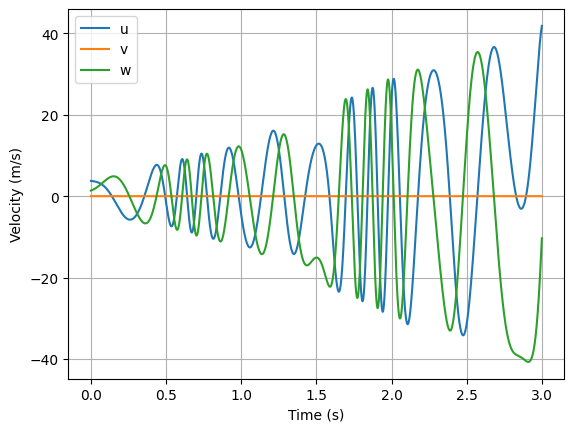

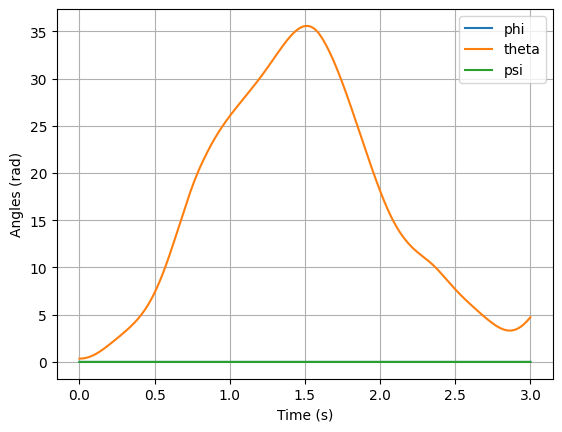

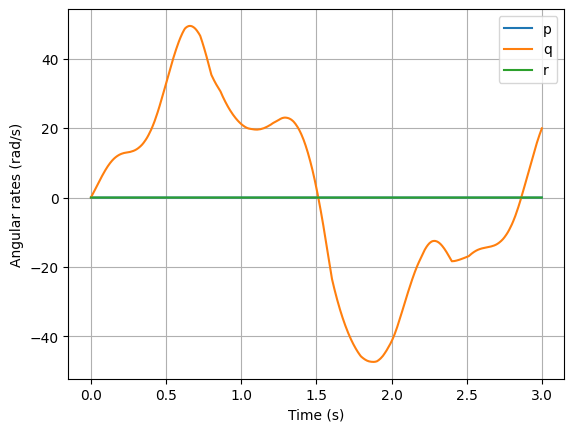

Simulation completed and results saved to 'results.csv' file.


In [36]:
T = 3 # Total time for the simulation 
t_step = T / 10000 # Time step for the simulation
t = 0 # Initial time

# Initial conditions
theta_deg = 20
theta= np.deg2rad(theta_deg)
speed = 4
u = speed*np.cos(theta)
v = 0
w = speed*np.sin(theta)
phi = 0
psi = 0
p = 0
q = 0
r = 0
flapping_period = 0.8

# Lists to store the results
u_list = []
v_list = []
w_list = []
phi_list = []
theta_list = []
psi_list = []
p_list = []
q_list = []
r_list = []
time_list = []

# Run the simulation

while t < T:
    # Calculate the aerodynamic forces and moments
    X, Y, Z, L, M, N = predict(speed, theta, t, flapping_period, phi, psi)

    # Calculate the accelerations
    accelerations = dynamics(p, q, r, u, v, w, phi, theta, psi, X, Y, Z, L, M, N)

    # Integrate to get new velocities
    u, v, w, p, q, r, phi, theta, psi = integrate(t, t_step, accelerations['u_dot'], accelerations['v_dot'], accelerations['w_dot'],
                                                  accelerations['p_dot'], accelerations['q_dot'], accelerations['r_dot'],
                                                  accelerations['phi_dot'], accelerations['theta_dot'], accelerations['psi_dot'],
                                                u, v, w, p, q, r, phi, theta, psi)

    # Append the results to the lists
    u_list.append(u)
    v_list.append(v)
    w_list.append(w)
    phi_list.append(phi)
    theta_list.append(theta)
    psi_list.append(psi)
    p_list.append(p)
    q_list.append(q)
    r_list.append(r)
    time_list.append(t)

    # Update the time
    t += t_step

# Convert the lists to NumPy arrays
u_array = np.array(u_list)
v_array = np.array(v_list)
w_array = np.array(w_list)
phi_array = np.array(phi_list)
theta_array = np.array(theta_list)
psi_array = np.array(psi_list)
p_array = np.array(p_list)
q_array = np.array(q_list)
r_array = np.array(r_list)
time_array = np.array(time_list)

# Plot the results
plt.figure()
plt.plot(time_array, u_array, label='u')
plt.plot(time_array, v_array, label='v')
plt.plot(time_array, w_array, label='w')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(time_array, phi_array, label='phi')
plt.plot(time_array, theta_array, label='theta')
plt.plot(time_array, psi_array, label='psi')
plt.xlabel('Time (s)')
plt.ylabel('Angles (rad)')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(time_array, p_array, label='p')
plt.plot(time_array, q_array, label='q')
plt.plot(time_array, r_array, label='r')
plt.xlabel('Time (s)')
plt.ylabel('Angular rates (rad/s)')
plt.legend()
plt.grid()
plt.show()

# Save the results to a CSV file
df = pd.DataFrame({
    'Time': time_array,
    'u': u_array,
    'v': v_array,
    'w': w_array,
    'phi': phi_array,
    'theta': theta_array,
    'psi': psi_array,
    'p': p_array,
    'q': q_array,
    'r': r_array
})
df.to_csv('results.csv', index=False)

print("Simulation completed and results saved to 'results.csv' file.")

